In [1]:
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Purpose

The purpose of this notebook is to implement/test the 2OI method for solving the Fokker-Planck equations detailed in the notebook "Numerical Solution for Fokker Planck Equations in Accelerators". The code is written in an editable format since we had to make minor tweaks throughout the processes of ensuring the error was accurate. Then the latter part of the code was written to analyze the convergence of the method with respect to both changing time step and changing length of each mesh cell.

# Exact Solution

Here we write out a series of functions that simulate the exact solution of the harmonic oscillator and plot out the exact solution at different time steps.

In [2]:
dim = 81

nx = np.linspace(-4,4,dim)
ny = np.linspace(-4,4,dim)

X, Y = np.meshgrid(nx,ny)

#Functions
K=1
gamma = 2.1
sigma = 0.8
delta_s = np.pi/1000

a_1 = lambda x,y: K*x
a_2 = lambda x,y: gamma*y
a_3 = lambda x,y: 0
a_4 = lambda x,y: sigma

delta_x = np.diff(X,axis=1).max()
delta_y = np.diff(Y,axis=0).max()

C = (a_1(X,Y)+a_2(X,Y))/2
D = 0.8
E = (D/delta_y)*np.ones(C.shape)
H = delta_s*Y/(2*delta_x)

In [3]:
mu_1 = -gamma/2+np.sqrt(gamma*gamma/4-K)
mu_2 = -gamma/2-np.sqrt(gamma*gamma/4-K)

xi = lambda x,v,t: (x*mu_1-v)*np.exp(-mu_2*t)
nu = lambda x,v,t: (x*mu_2-v)*np.exp(-mu_1*t)

a = lambda t: (sigma/mu_1)*(1-np.exp(-2*mu_1*t))
b = lambda t: (sigma/mu_2)*(1-np.exp(-2*mu_2*t))
h = lambda t: (-2*sigma/(mu_1+mu_2))*(1-np.exp(-(mu_1+mu_2)*t))
delta = lambda t: a(t)*b(t)-h(t)*h(t)

y_0=0
x_0=0

top = lambda x,y,t: (a(t)*(xi(x,y,t)-xi(x_0,y_0,0))**2+2*h(t)*(xi(x,y,t)-xi(x_0,y_0,0))*(nu(x,y,t)-nu(x_0,y_0,0))+b(t)*(nu(x,y,t)-nu(x_0,y_0,0))**2)/(2*delta(t))
rho = lambda x,y,t: np.exp(gamma*t)*np.exp(-top(x,y,t))/(2*np.pi*np.sqrt(delta(t)))

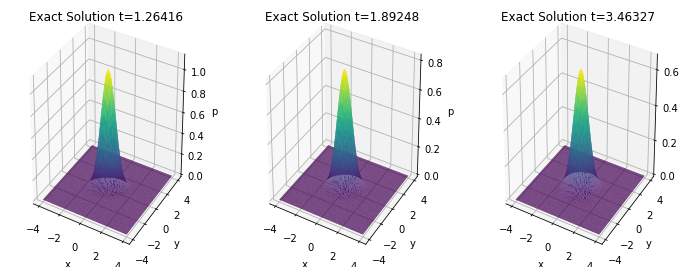

In [4]:
# Make the plot
fig = plt.figure(figsize=plt.figaspect(1/3))

#Time at t=1.26416
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_trisurf(Y.flatten(), X.flatten(), rho(X,Y,1.26416).flatten(), cmap=plt.cm.viridis, linewidth=0.2)
ax.set_title("Exact Solution t={}".format(1.26416))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p")
 
#Time at t=1.89248
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_trisurf(Y.flatten(), X.flatten(), rho(X,Y,1.89248).flatten(), cmap=plt.cm.viridis, linewidth=0.2)
ax.set_title("Exact Solution t={}".format(1.89248))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p")
 
#Time at t=3.46327
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_trisurf(Y.flatten(), X.flatten(), rho(X,Y,3.46327).flatten(), cmap=plt.cm.viridis, linewidth=0.2)
ax.set_title("Exact Solution t={}".format(3.46327))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p")

# Rotate it
# ax.view_init(30, 45)
plt.subplots_adjust(bottom=0)
plt.show()
 
# # Other palette
# ax.plot_trisurf(Y, X, rho(X,Y,t), cmap=plt.cm.jet, linewidth=0.01)
# plt.show()

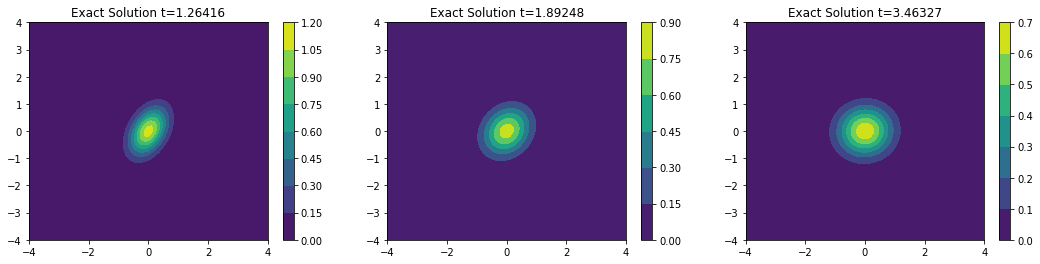

In [5]:
fig = plt.figure(figsize=plt.figaspect(1/3))

#Time at t=1.26416
plt.subplot(131)
plt.contourf(X,Y,rho(X,Y,1.26416))
plt.title("Exact Solution t={}".format(1.26416))
plt.colorbar()

#Time at t=1.89248
plt.subplot(132)
plt.contourf(X,Y,rho(X,Y,1.89248))
plt.title("Exact Solution t={}".format(1.89248))
plt.colorbar()

#Time at t=3.46327
plt.subplot(133)
plt.contourf(X,Y,rho(X,Y,3.46327))
plt.title("Exact Solution t={}".format(3.46327))
plt.colorbar()

plt.subplots_adjust(right=1.3)

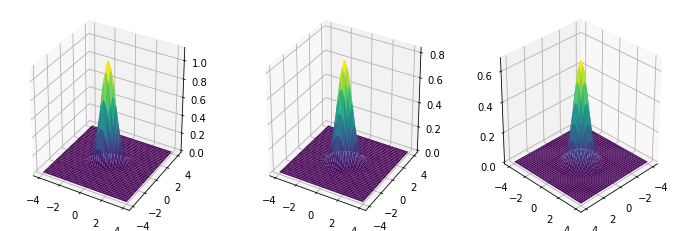

In [6]:
# Make the plot
fig = plt.figure(figsize=plt.figaspect(1/3))

#Time at t=1.26416
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(Y, X, rho(X,Y,1.26416), cmap=plt.cm.viridis, linewidth=0.2)
 
#Time at t=1.89248
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(Y, X, rho(X,Y,1.89248), cmap=plt.cm.viridis, linewidth=0.2)
 
#Time at t=3.46327
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(Y, X, rho(X,Y,3.46327), cmap=plt.cm.viridis, linewidth=0.2)

# Rotate it
ax.view_init(30, 45)
# plt.subplots_adjust()
plt.show()
 
# # Other palette
# ax.plot_trisurf(Y, X, rho(X,Y,t), cmap=plt.cm.jet, linewidth=0.01)
# plt.show()

# Accurate Simulation

In this section we use the 2OI approach to time evolve the system and calculate its error with respect to the exact solution.

In [7]:
dim = 81

nx = np.linspace(-4,4,dim)
ny = np.linspace(-4,4,dim)

X, Y = np.meshgrid(nx,ny)

#Functions
K=1
gamma = 2.1
sigma = 0.8
delta_s = np.pi/1000

a_1 = lambda x,y: K*x
a_2 = lambda x,y: gamma*y
a_3 = lambda x,y: 0
a_4 = lambda x,y: sigma

delta_x = np.diff(X,axis=1).max()
delta_y = np.diff(Y,axis=0).max()

C = (a_1(X,Y)+a_2(X,Y))/2
D = 0.8
E = (D/delta_y)*np.ones(C.shape)
H = delta_s*Y/(2*delta_x)

In [8]:
mu_1 = -gamma/2+np.sqrt(gamma*gamma/4-K)
mu_2 = -gamma/2-np.sqrt(gamma*gamma/4-K)

xi = lambda x,v,t: (x*mu_1-v)*np.exp(-mu_2*t)
nu = lambda x,v,t: (x*mu_2-v)*np.exp(-mu_1*t)

a = lambda t: (sigma/mu_1)*(1-np.exp(-2*mu_1*t))
b = lambda t: (sigma/mu_2)*(1-np.exp(-2*mu_2*t))
h = lambda t: (-2*sigma/(mu_1+mu_2))*(1-np.exp(-(mu_1+mu_2)*t))
delta = lambda t: a(t)*b(t)-h(t)*h(t)

y_0=0
x_0=0

top = lambda x,y,t: (a(t)*(xi(x,y,t)-xi(x_0,y_0,0))**2+2*h(t)*(xi(x,y,t)-xi(x_0,y_0,0))*(nu(x,y,t)-nu(x_0,y_0,0))+b(t)*(nu(x,y,t)-nu(x_0,y_0,0))**2)/(2*delta(t))
rho = lambda x,y,t: np.exp(gamma*t)*np.exp(-top(x,y,t))/(2*np.pi*np.sqrt(delta(t)))

Simulating


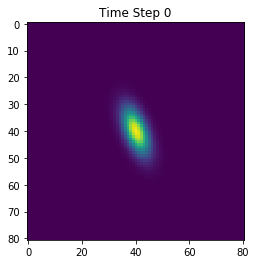

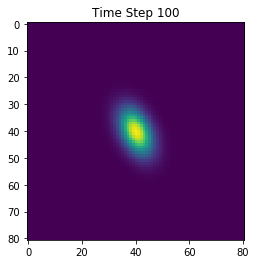

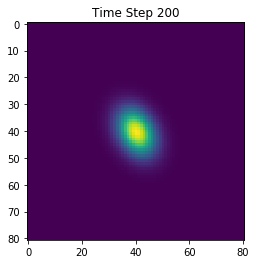

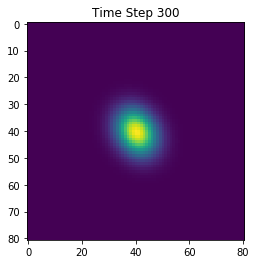

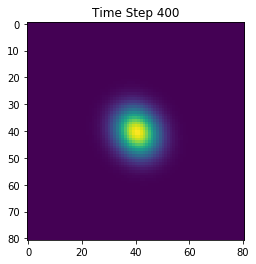

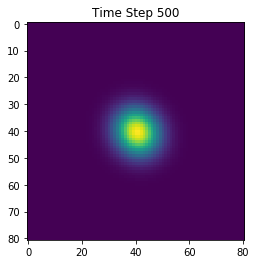

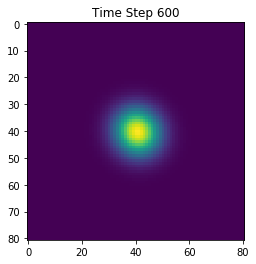

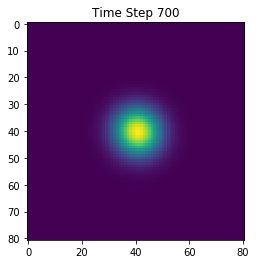

In [9]:
Us = []
Us_half = []
errors = []

#Establishing the Exact Solution
t_nx = np.linspace(-4,4,dim)
t_ny = np.linspace(-4,4,dim)

t_X, t_Y = np.meshgrid(t_nx,t_ny)

t= .95

U=rho(t_X,t_Y,.95)


#Simulating
print("Simulating")

runs = 800
for j in range(runs):
    #Building an Empty Solution
    x1_dim, x2_dim = U.shape
    U_half = np.empty((x1_dim,x2_dim))
    t+=delta_s
    
    #Meant to run through the first operator through the entire array
    for i in range(x1_dim):
        test = U[:,i]

        temp = C[:,i].copy()
        E_temp= E[:,i].copy()

        top_diag = temp[:-1]
        bot_diag = temp[:-1]

        E_top_diag = E_temp[1:]
        E_bot_diag = E_temp[:-1]
        
        #Building the matrix for the x_2 derivative
        mid_diag = np.pad(bot_diag[:-1]-top_diag[1:],((1,1)),'constant')+np.pad(E_bot_diag[:-1]+E_top_diag[1:],((1,1)),'constant')
        A = np.diag(top_diag,1)-np.diag(bot_diag,-1)-np.diag(mid_diag,0)+np.diag(E_top_diag,1)+np.diag(E_bot_diag,-1)
        A*=(delta_s/delta_y)
        A+= -np.eye(dim)
        A[0,1]=0
        A[-1,-2]=0
        
        U_half[:,i] = np.linalg.solve(A,-test)
    
    Us_half.append(U_half)
    
    x1_dim, x2_dim = U.shape
    U_new = np.empty((x1_dim,x2_dim))
    
    #Meant to run through the second operator through the entire array
    for i in range(x2_dim):
        test = U_half[i]

        temp = H[i].copy()
        top_diag = temp[1:]
        bot_diag = temp[:-1]
        
        #Building the matrix for the x_1 derivative
        B = np.eye(dim)+np.diag(top_diag,1)-np.diag(bot_diag,-1)
        B[0,1]=0
        B[-1,-2]=0
        
        U_new[i]=np.linalg.solve(B,test)
    
    #Setting the new solution
    U=U_new
    
    #Keeping Track of the Solutions
    if j%100==0:
        plt.figure()
        plt.title("Time Step {}".format(j))
        plt.imshow(U)
    Us.append(U)
    
    #Keeping Track of the Errors
    errors.append(np.sqrt(np.sum((rho(X,Y,t)-U)*(rho(X,Y,t)-U)/(81*81))))
    

Text(0, 0.5, 'Error ||e|||')

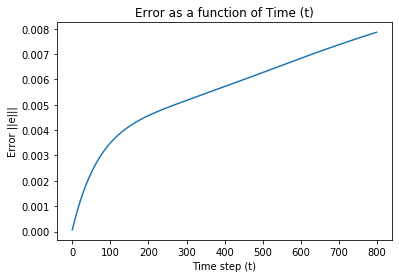

In [10]:
plt.plot(errors)
plt.title("Error as a function of Time (t)")
plt.xlabel("Time step (t)")
plt.ylabel("Error ||e|||")

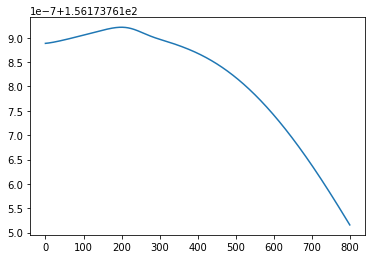

In [11]:
#Checking the total value of the solution to ensure there is no probability loss
plt.plot([np.sum(u) for u in Us])

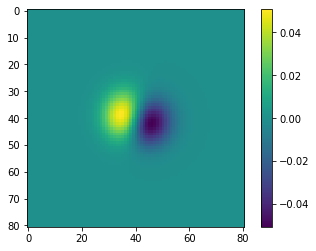

In [12]:
#Checking the difference between the actual solution and the calculated solution
plt.imshow(rho(X,Y,t)-Us[runs-1]);plt.colorbar()

In [13]:
#Calculating the total error between the actual value and the expected value
np.sqrt(np.sum((rho(X,Y,t)-Us[runs-1])*(rho(X,Y,t)-Us[runs-1])/(81*81)))

0.007862812638001229

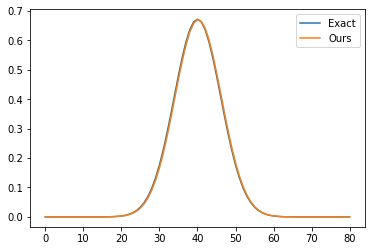

In [14]:
#Comparison of line profiles of each solution
plt.plot(rho(X,Y,t)[:,40],label="Exact")
plt.plot(Us[runs-1][:,40],label="Ours")
plt.legend()

# Checking Space Complexity

For the 2OI method we examine the space complexity: the error of the method plotted against the side length of the mesh.

In [15]:
def run_at_dim(dim=81):
    nx = np.linspace(-4,4,dim)
    ny = np.linspace(-4,4,dim)

    X, Y = np.meshgrid(nx,ny)

    #Functions
    K=1
    gamma = 2.1
    sigma = 0.8
    delta_s = np.pi/1000

    a_1 = lambda x,y: K*x
    a_2 = lambda x,y: gamma*y
    a_3 = lambda x,y: 0
    a_4 = lambda x,y: sigma

    delta_x = np.diff(X,axis=1).max()
    delta_y = np.diff(Y,axis=0).max()

    C = (a_1(X,Y)+a_2(X,Y))/2
    D = 0.8
    E = (D/delta_y)*np.ones(C.shape)
    H = delta_s*Y/(2*delta_x)

    Us = []
    Us_half = []
    errors = []

    #Establishing the Exact Solution
    t_nx = np.linspace(-4,4,dim)
    t_ny = np.linspace(-4,4,dim)

    t_X, t_Y = np.meshgrid(t_nx,t_ny)

    t= .95

    U=rho(t_X,t_Y,.95)


    #Simulating
    print("Simulating")

    runs = 300
    for j in range(runs):
        #Building an Empty Solution
        x1_dim, x2_dim = U.shape
        U_half = np.empty((x1_dim,x2_dim))
        t+=delta_s

        #Meant to run through the first operator through the entire array
        for i in range(x1_dim):
            test = U[:,i]

            temp = C[:,i].copy()
            E_temp= E[:,i].copy()

            top_diag = temp[:-1]
            bot_diag = temp[:-1]

            E_top_diag = E_temp[1:]
            E_bot_diag = E_temp[:-1]

            #Building the matrix for the x_2 derivative
            mid_diag = np.pad(bot_diag[:-1]-top_diag[1:],((1,1)),'constant')+np.pad(E_bot_diag[:-1]+E_top_diag[1:],((1,1)),'constant')
            A = np.diag(top_diag,1)-np.diag(bot_diag,-1)-np.diag(mid_diag,0)+np.diag(E_top_diag,1)+np.diag(E_bot_diag,-1)
            A*=(delta_s/delta_y)
            A+= -np.eye(dim)
            A[0,1]=0
            A[-1,-2]=0

            U_half[:,i] = np.linalg.solve(A,-test)

        Us_half.append(U_half)

        x1_dim, x2_dim = U.shape
        U_new = np.empty((x1_dim,x2_dim))

        #Meant to run through the second operator through the entire array
        for i in range(x2_dim):
            test = U_half[i]

            temp = H[i].copy()
            top_diag = temp[1:]
            bot_diag = temp[:-1]

            #Building the matrix for the x_1 derivative
            B = np.eye(dim)+np.diag(top_diag,1)-np.diag(bot_diag,-1)
            B[0,1]=0
            B[-1,-2]=0

            U_new[i]=np.linalg.solve(B,test)

        #Setting the new solution
        U=U_new

        #Keeping Track of the Solutions
#         if j%100==0:
#             plt.figure()
#             plt.title("Time Step {}".format(j))
#             plt.imshow(U)
#         Us.append(U)

        #Keeping Track of the Errors
        errors.append(np.sqrt(np.sum((rho(X,Y,t)-U)*(rho(X,Y,t)-U)/(81*81))))
    return errors[-1]

In [16]:
space_complex = [run_at_dim(dim=d) for d in [21,41,61,81,121]]

Simulating
Simulating
Simulating
Simulating
Simulating


Text(0.5, 0, '$\\Delta$ x')

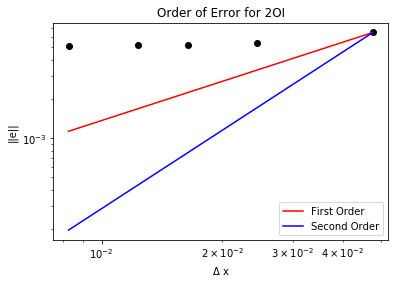

In [17]:
f = lambda xs, order: np.power(xs/xs[0],order)

delta_xs = np.array([1/21,1/41,1/61,1/81,1/121])

plt.title("Order of Error for 2OI")
plt.loglog(delta_xs,space_complex,'ko')
plt.loglog(delta_xs,space_complex[0]*f(delta_xs,1),label="First Order",c='r')
plt.loglog(delta_xs,space_complex[0]*f(delta_xs,2),label="Second Order",c='b')
plt.legend()
plt.ylabel("||e||")
plt.xlabel(r"$\Delta$ x")

# Checking Time Complexity

For the 2OI method we examine the time complexity: the error of the method plotted against time step taken.

In [18]:
def run_at_time(runs=800):
    dim=81
    nx = np.linspace(-4,4,dim)
    ny = np.linspace(-4,4,dim)

    X, Y = np.meshgrid(nx,ny)

    #Functions
    K=1
    gamma = 2.1
    sigma = 0.8
    delta_s = 800*(np.pi/(1000*runs))

    a_1 = lambda x,y: K*x
    a_2 = lambda x,y: gamma*y
    a_3 = lambda x,y: 0
    a_4 = lambda x,y: sigma

    delta_x = np.diff(X,axis=1).max()
    delta_y = np.diff(Y,axis=0).max()

    C = (a_1(X,Y)+a_2(X,Y))/2
    D = 0.8
    E = (D/delta_y)*np.ones(C.shape)
    H = delta_s*Y/(2*delta_x)

    Us = []
    Us_half = []
    errors = []

    #Establishing the Exact Solution
    t_nx = np.linspace(-4,4,dim)
    t_ny = np.linspace(-4,4,dim)

    t_X, t_Y = np.meshgrid(t_nx,t_ny)

    t= .95

    U=rho(t_X,t_Y,.95)


    #Simulating
    print("Simulating")

    for j in range(runs):
        #Building an Empty Solution
        x1_dim, x2_dim = U.shape
        U_half = np.empty((x1_dim,x2_dim))
        t+=delta_s

        #Meant to run through the first operator through the entire array
        for i in range(x1_dim):
            test = U[:,i]

            temp = C[:,i].copy()
            E_temp= E[:,i].copy()

            top_diag = temp[:-1]
            bot_diag = temp[:-1]

            E_top_diag = E_temp[1:]
            E_bot_diag = E_temp[:-1]

            #Building the matrix for the x_2 derivative
            mid_diag = np.pad(bot_diag[:-1]-top_diag[1:],((1,1)),'constant')+np.pad(E_bot_diag[:-1]+E_top_diag[1:],((1,1)),'constant')
            A = np.diag(top_diag,1)-np.diag(bot_diag,-1)-np.diag(mid_diag,0)+np.diag(E_top_diag,1)+np.diag(E_bot_diag,-1)
            A*=(delta_s/delta_y)
            A+= -np.eye(dim)
            A[0,1]=0
            A[-1,-2]=0

            U_half[:,i] = np.linalg.solve(A,-test)

        Us_half.append(U_half)

        x1_dim, x2_dim = U.shape
        U_new = np.empty((x1_dim,x2_dim))

        #Meant to run through the second operator through the entire array
        for i in range(x2_dim):
            test = U_half[i]

            temp = H[i].copy()
            top_diag = temp[1:]
            bot_diag = temp[:-1]

            #Building the matrix for the x_1 derivative
            B = np.eye(dim)+np.diag(top_diag,1)-np.diag(bot_diag,-1)
            B[0,1]=0
            B[-1,-2]=0

            U_new[i]=np.linalg.solve(B,test)

        #Setting the new solution
        U=U_new

        #Keeping Track of the Solutions
#         if j%100==0:
#             plt.figure()
#             plt.title("Time Step {}".format(j))
#             plt.imshow(U)
#         Us.append(U)

        #Keeping Track of the Errors
        errors.append(np.sqrt(np.sum((rho(X,Y,t)-U)*(rho(X,Y,t)-U)/(81*81))))
    return errors[-1]

In [19]:
time_complex = [run_at_time(runs=d) for d in [100,200,400,800]]

Simulating
Simulating
Simulating
Simulating


In [20]:
time_complex

[0.007829639854580985,
 0.00781559823588177,
 0.007841282644174833,
 0.007862812638001877]

Text(0.5, 0, '$\\Delta$ t')

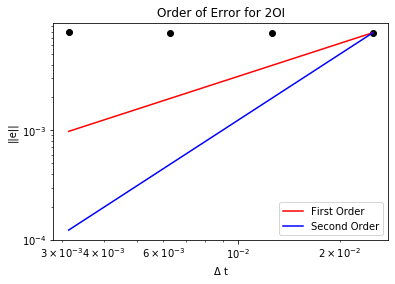

In [21]:
f = lambda xs, order: np.power(xs/xs[0],order)

delta_ts = 800*(np.pi/(1000*np.array([100,200,400,800])))

plt.title("Order of Error for 2OI")
plt.loglog(delta_ts,time_complex,'ko')
plt.loglog(delta_ts,time_complex[0]*f(delta_ts,1),label="First Order",c='r')
plt.loglog(delta_ts,time_complex[0]*f(delta_ts,2),label="Second Order",c='b')
plt.legend()
plt.ylabel("||e||")
plt.xlabel(r"$\Delta$ t")